In [1]:
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from prettytable import PrettyTable
print(torch.cuda.is_available())
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.memory_allocated())
gpu_id = 2

True
11721506816
0


In [2]:
!nvidia-smi

Wed Jul 14 20:49:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 19%   35C    P0    60W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 18%   36C    P0    59W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
my_path = '../../dataset/sharma_59_nih_dataset/Image_dataset/'
path_0 = my_path+'0_0/'
path_1 = my_path + '1_1/'
print(len(os.listdir(path_0)))
print(len(os.listdir(path_1)))


# torchvision.transforms.Normalize(mean=torch.rand(3),std = torch.rand(3))
transformations = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                                  torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor()])

images = torchvision.datasets.ImageFolder(root=my_path,transform=transformations)
train_data,validate_data,test_data = torch.utils.data.dataset.random_split(images,[8020,2286,1146])
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=64,shuffle=True)
validate_loader = torch.utils.data.DataLoader(dataset = validate_data,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=64,shuffle=True)


print(images.class_to_idx)

5727
5725
{'0_0': 0, '1_1': 1}


In [4]:
def check_acc(loader,model,name,fpr={},tpr={},auc_={}):
    model.eval()
    correct = 0;samples=0

    pre = []
    lab = []
    predicted_labels = []
    
    with torch.no_grad():
        for idx,(x, y) in enumerate(loader):
            
            x = Normalize_data(x)
            x = x.cuda(gpu_id)
            y = y.cuda(gpu_id)
            
            scores=model(x)
            predict_prob = F.softmax(scores)
            _,predictions=predict_prob.max(1)
            
            predictions = predictions.to('cpu')
            y = y.to('cpu')
            predict_prob = predict_prob.to('cpu')
            
            predicted_labels.extend(list(predictions.numpy()))
            pre.extend(list(predict_prob.numpy()))
            lab.extend(list(y.numpy()))
            
            correct += (predictions==y).sum()
            samples += predictions.size(0)
            
            torch.cuda.empty_cache()
        
        print(f'correct are {correct}/{samples}')
        
        lab = np.array(lab)
        pre = np.array(pre)
        
    fpr[name],tpr[name],_= roc_curve(lab,pre[:,1])
    auc_[name] = auc(fpr[name],tpr[name])
    model.train()
    return lab,pre,predicted_labels,correct/samples

def check_acc_batch(batch,labels,model):
    model.eval()
    correct = 0
    samples=0
    with torch.no_grad():
        
        scores=model(batch)
        scores = F.softmax(scores)
        _,predicted = torch.max(scores,axis=1)
        correct += (predicted==labels).sum()
        samples += scores.shape[0]
#         print(f"correct : [{correct}/{samples}]")
        torch.cuda.empty_cache()

    model.train()
    return correct/samples




def Normalize_data(data):
#     data = data/255
    for i in range(data.shape[0]):
        mean = torch.mean(data[i],dim = [1,2])
        std = torch.std(data[i],dim=[1,2])
        transform = transforms.Compose([transforms.Normalize(mean,std)])
        data[i] = transform(data[i])
    return data

def Normalize_data_train(data):
#     data = data/255
    for i in range(data.shape[0]):
        mean = torch.mean(data[i],dim = [1,2])
        std = torch.std(data[i],dim=[1,2])
        transform = transforms.Compose([transforms.RandomHorizontalFlip(p = 0.6),
#                                         transforms.RandomRotation(10),
                                        transforms.Normalize(mean,std)])
        data[i] = transform(data[i])
    return data




def count_parameters(model):
    table = PrettyTable(["layer", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    


In [5]:
def train_model(model1,Losses_,optimizer,schedular,lr,n_epochs,overall_loss=[],overall_acc=[],val_loss=[],val_accuracy=[]):
    weight_decay = 0.0001
    
    best_validation_acc = 0.5
    best_model = model1.state_dict()
    best_optimizer = optimizer.state_dict()
    
    for epochs in range(n_epochs):
        batch_loss = []
        batch_acc = [] 
        val_batch_loss= []
        val_batch_acc = []
        for idx , (data,target) in enumerate(train_loader):


            """ mean normalization """
            data = Normalize_data_train(data)
            
            data = data.cuda(gpu_id)
            target = target.cuda(gpu_id)
            
            scores = model1(data)
            
#             l1_reg_loss = 0
#             for params in model1.parameters():
#                 l1_reg_loss += torch.sum(abs(params))
                
            loss = Losses_(scores,target)#+ weight_decay*l1_reg_loss
            batch_loss.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_accuracy = check_acc_batch(data,target,model1)
            batch_acc.append(float(batch_accuracy))
            
        model1.eval()

        for idx ,(data,target) in enumerate(validate_loader):

            data = Normalize_data(data)

            data = data.cuda(gpu_id)
            target = target.cuda(gpu_id)

            scores = model1(data)
            loss = Losses_(scores,target)
            val_batch_loss.append(float(loss))

            batch_accuracy = check_acc_batch(data,target,model1)
            val_batch_acc.append(float(batch_accuracy))

        model1.train()

        occupied_memory = torch.cuda.memory_allocated(gpu_id)/(1024*1024*1024)
        total_memory = torch.cuda.get_device_properties(gpu_id).total_memory/(1024*1024*1024)

        overall_loss.append(batch_loss)
        overall_acc.append(batch_acc)
        val_loss.append(val_batch_loss)
        val_accuracy.append(val_batch_acc)

        valid_acc = np.mean(val_batch_acc)
        if(valid_acc > best_validation_acc):
            best_validation_acc = valid_acc
            best_model = model1.state_dict()
            best_optimizer = optimizer.state_dict()

        print(f'epoch:[{epochs+1}/{n_epochs}],memory:[{occupied_memory}/{total_memory}]') 
        print(f'train_accuracy:{np.mean(batch_acc)}, train_loss:{np.mean(batch_loss)},val_acc:{np.mean(val_batch_acc)},val_loss:{np.mean(val_batch_loss)} ,learning_rate:{optimizer.param_groups[0]["lr"]}')
            
    return best_model,best_optimizer

      
      

In [6]:
mob_v2 = torchvision.models.mobilenet_v2(pretrained=True)
print(mob_v2)
count_parameters(mob_v2)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [7]:
mob_v2.classifier[1] = nn.Sequential(nn.Linear(1280,256),
                                    nn.ReLU(),
                                    nn.Linear(256,2))

print(mob_v2)
count_parameters(mob_v2)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [8]:
mob_v2 = mob_v2.cuda(gpu_id)

In [9]:

Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=mob_v2.parameters(),lr=lr,weight_decay=1e-4)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=8,gamma=0.1)
overall_loss=[]
overall_acc=[]
val_loss=[]
val_accuracy=[]
n_epochs=50
best_model,best_optimizer = train_model(mob_v2,Losses_,optimizer,schedular,lr,n_epochs,overall_loss,overall_acc,val_loss,val_accuracy)


epoch:[1/50],memory:[2.388082504272461/10.91650390625]
train_accuracy:0.6752232142857143, train_loss:0.6236111393996647,val_acc:0.6677611718575159,val_loss:0.6158691263861127 ,learning_rate:0.0003
epoch:[2/50],memory:[2.388082504272461/10.91650390625]
train_accuracy:0.7129712303479513, train_loss:0.5881976989053544,val_acc:0.6809895833333334,val_loss:0.610773021976153 ,learning_rate:0.0003
epoch:[3/50],memory:[2.388082504272461/10.91650390625]
train_accuracy:0.7247023809523809, train_loss:0.5706055315714034,val_acc:0.6841787447532018,val_loss:0.6016238894727495 ,learning_rate:0.0003
epoch:[4/50],memory:[2.388082504272461/10.91650390625]
train_accuracy:0.7441220240933555, train_loss:0.5489729195833206,val_acc:0.687650966975424,val_loss:0.6073217425081465 ,learning_rate:0.0003
epoch:[5/50],memory:[2.388082504272461/10.91650390625]
train_accuracy:0.7697420635866741, train_loss:0.5124668277918346,val_acc:0.6734790156284968,val_loss:0.6296706116861768 ,learning_rate:0.0003
epoch:[6/50],memo

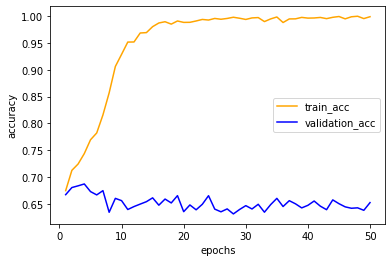

In [10]:
plt.plot(list(range(1,n_epochs+1)),np.mean(overall_acc,axis=1),color='orange',label='train_acc')
plt.plot(list(range(1,n_epochs+1)),np.mean(val_accuracy,axis=1),color='blue',label='validation_acc')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

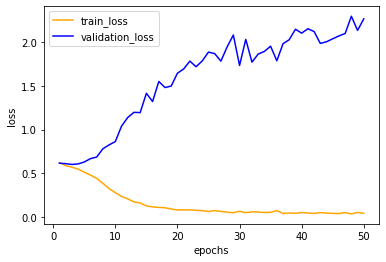

In [11]:
plt.plot(list(range(1,n_epochs+1)),np.mean(overall_loss,axis=1),color='orange',label='train_loss')
plt.plot(list(range(1,n_epochs+1)),np.mean(val_loss,axis=1),color='blue',label='validation_loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [12]:
fpr = {}
tpr = {}
auc_ = {}
labels_test,prob_test,predicted_test,acc_test = check_acc(test_loader,mob_v2,'test',fpr,tpr,auc_)
print(acc_test)
labels_train,prob_train,predicted_train,acc_train = check_acc(train_loader,mob_v2,'train',fpr,tpr,auc_)
print(acc_train)
labels_valid,prob_valid,predicted_valid,acc_valid = check_acc(validate_loader,mob_v2,'val',fpr,tpr,auc_)
print(acc_valid)

correct are 737/1146
tensor(0.6431)
correct are 7957/8020
tensor(0.9921)
correct are 1491/2286
tensor(0.6522)


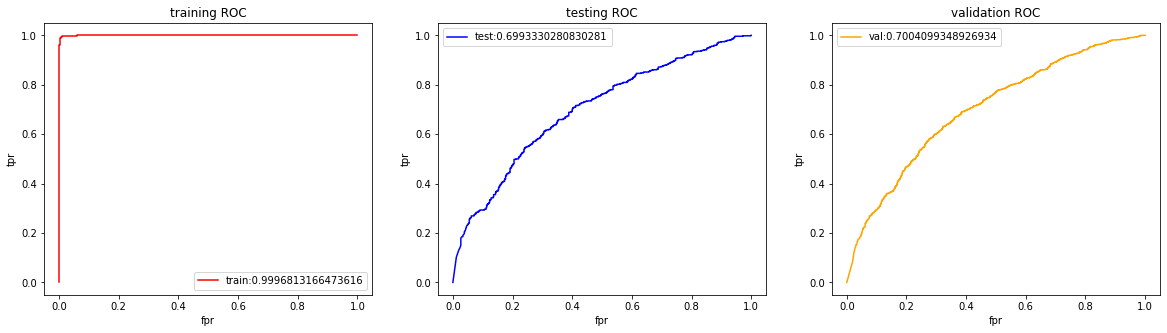

In [13]:
figure , axis = plt.subplots(1,3,figsize=(20,5))

axis[0].plot(fpr['train'],tpr['train'],label=f"train:{auc_['train']}",color='red')
axis[0].set_xlabel('fpr')
axis[0].set_ylabel('tpr')
axis[0].legend()
axis[0].set_title('training ROC')

axis[1].plot(fpr['test'],tpr['test'],label=f"test:{auc_['test']}",color='blue')
axis[1].set_xlabel('fpr')
axis[1].set_ylabel('tpr')
axis[1].legend()
axis[1].set_title('testing ROC')

axis[2].plot(fpr['val'],tpr['val'],label=f"val:{auc_['val']}",color='orange')
axis[2].set_xlabel('fpr')
axis[2].set_ylabel('tpr')
axis[2].legend()
axis[2].set_title('validation ROC')

plt.show()


[[371 229]
 [180 366]]
precision :  0.6151260504201681
recall :  0.6703296703296703


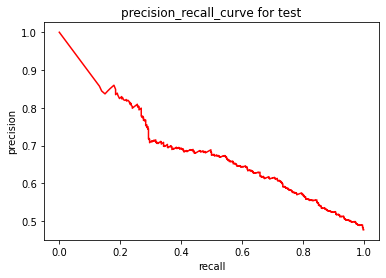

In [14]:
print(confusion_matrix(labels_test,predicted_test))
print("precision : ",precision_score(labels_test,predicted_test))
print("recall : ",recall_score(labels_test,predicted_test))
precision_test,recall_test,_= precision_recall_curve(labels_test,prob_test[:,1])
plt.plot(recall_test,precision_test,color='red')
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision_recall_curve for test")
plt.show()

[[3925   47]
 [  16 4032]]
precision :  0.9884775680313802
recall :  0.9960474308300395


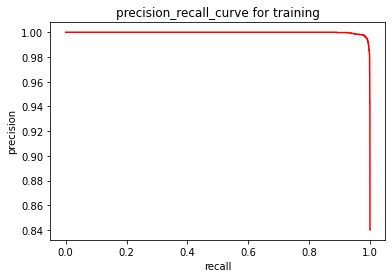

In [15]:
print(confusion_matrix(labels_train,predicted_train))
print("precision : ",precision_score(labels_train,predicted_train))
print("recall : ",recall_score(labels_train,predicted_train))
precision_train,recall_train,_= precision_recall_curve(labels_train,prob_train[:,1])
plt.plot(recall_train,precision_train,color='red')
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision_recall_curve for training")
plt.show()

In [17]:
my_dir = 'saved_models/mobile_net_v2_cuda2.pth'
try:
    torch.save({'best_model':best_model,'best_opt':best_optimizer},my_dir)
    print("model saved")
except Exception as e:
    print(e)
    

model saved


In [1]:
from pyt_model_class import Model_class

In [2]:
print(dir(Model_class))

['Normalize', 'Normalize_train', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'accuracy_curve', 'evaluate', 'evaluate_batch', 'loss_curve', 'plot_precision_recall', 'plot_roc', 'print_params', 'save_model', 'train']
